In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# IMPORTANT NOTE ! - LIST ASSUMPTIONS BEING MADE FOR THIS ALGORITHM APPLICATION

## we are not using flower framework to apply the federated learning for the sake of simplicity.. we are concentrated on the drift detection algorithm of Fed-Drift Eager (algorithm 3 in mentioned in the Federated Learning under Distributed Concept Drift paper)

## here are the list of assumptions being made :

### * let it be noted that we aren't actually creating the Federated learning architecture, we ares imply simulating it here.
###   We are also directly making changes and training the instances of models here. 

### * the local datasets are also not provided, therefore we take a subset of the train dataset  

### * we are creating a matrix of (number of clients ) * (number of models of each client) for losses and tally for 1 particular round


### * loss is calculated for each round where the loss matrix is a 3 dimensional matrix of shape:
###      (number of rounds) * (number of clients ) * (number of models of each client)



### * the dimension of 'number of models' changes everytime a concept drift is during the communication round and a new global model is created. For the next round, therefore , a new column is created for 1 particular round.


### * 

In [28]:
# Load and preprocess MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

In [29]:
test_images.shape

(10000, 28, 28, 1)

In [30]:
train_images.shape

(60000, 28, 28, 1)

In [31]:
test_labels.shape

(10000,)

In [32]:
test_images=test_images.reshape((10000,784))
train_images=train_images.reshape((60000,784))
test_images.shape

(10000, 784)

In [33]:
# defining the parameters

num_clients =5
num_models=3
num_rounds=5
threshold=0.016

#algorithm 1 parameters :

num_local_steps = 20
minibatch_size = 100

In [34]:
l=len(test_images)//num_clients
clients_data=[x for x in range(0,len(test_images),l)]
clients_labels=[x for x in range(0,len(test_images),l)]

clients_data=np.split(test_images,clients_data)
clients_labels=np.split(test_labels,clients_labels)

print(len(clients_data))
print(l)
print(len(test_images))

6
2000
10000


In [35]:
loss_func=tf.keras.losses.sparse_categorical_crossentropy

In [36]:
def ANN_model():
    model=keras.Sequential()
    model.add(keras.layers.InputLayer(shape=(784,)))
    model.add(keras.layers.Dense(382,activation="relu"))
    model.add(keras.layers.Dense(100,activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(10,activation="softmax"))
    
    model.compile(optimizer="adam",loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [37]:
for i in range(len(clients_data)):
    print(len(clients_data[i]))

0
2000
2000
2000
2000
2000


In [38]:
clients_data=clients_data[1:]

In [39]:
for i in range(len(clients_labels)):
    print(len(clients_labels[i]))

0
2000
2000
2000
2000
2000


In [40]:
clients_labels=clients_labels[1:]

In [41]:
global_models=[ANN_model() for _ in range(num_models)]

In [42]:
client_models=[global_models.copy() for _ in range(num_clients)]
print("(",len(client_models),",",len(client_models[0]),")")

( 5 , 3 )


In [43]:
client_models

[[<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>]]

In [44]:
type(client_models)

list

In [45]:
weights_assn=np.zeros((num_clients,num_models),dtype="int8")
weights_assn.shape

(5, 3)

In [46]:
tally_arr=np.stack([weights_assn]*num_rounds,axis=1)
tally_arr.dtype="int8"
tally_arr.shape

(5, 5, 3)

In [47]:
weights_assn=np.zeros((num_clients,num_models),dtype="float16")
weights_assn.shape

rounds_losses=np.stack([weights_assn]*num_rounds,axis=1)
rounds_losses.dtype="float16"
rounds_losses.shape
rounds_losses=list(rounds_losses)

In [48]:
# Define LOCALUPDATE function for local model updates
def LOCALUPDATE(c, hm, w_c_m, data, minibatch_size, num_local_steps):
    print("loco update ")
    for _ in range(num_local_steps):
        # Sample a random minibatch
        population_size = len(data[0])
        if population_size < minibatch_size:
            replace = True  # Set replace to True if population size is smaller than minibatch size
        else:
            replace = False
        indices = np.random.choice(population_size, minibatch_size, replace=replace)
        minibatch_images = data[0][indices]
        minibatch_labels = data[1][indices]
        
        hm.fit(minibatch_images,minibatch_labels,epochs = 1,verbose=0)
        
    return hm


In [49]:
client_models

[[<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>],
 [<Sequential name=sequential_5, built=True>,
  <Sequential name=sequential_6, built=True>,
  <Sequential name=sequential_7, built=True>]]

In [50]:
tally_arr

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=int8)

In [51]:
def merge_weights(new_weights_arr,old_weights_arr):

    merg=[]
    for i,j in zip(new_weights_arr,old_weights_arr):
        tempora=[]

        #print(len(i)," ",len(j))
       # print("*"*20)
        for x,y in zip(i,j):
            #print("#"*25)
            #print(len(x),len(y))
            
            temp_sum=(np.array(x)+np.array(y))/2
            #print("temporary sum : ",len(temp_sum))
            #print("type of ",type(temp_sum))
            tempora.append(temp_sum)
        merg.append(tempora)
        
    print("merge len : ",len(merg))
    return merg


In [52]:
import random 
# random.randint() will give randomized data chunks required to train the models, as same data trained model will give same losses

# fed-drift algorithm
#rounds_losses=[]

random.seed(256)
for k in range(num_rounds):
    print("local round no : ",(k+1))
    weights_assn=np.zeros((num_clients,num_models))
    clients_list=[]
    
    drift_det=False
    new_mod=[]
    
    for i in range(num_clients):
        print("client no. : ",(i+1))
        client_model_weights=[]
        
        for j in range(len(client_models[i])):

            temp_mod=client_models[i][j]
            #temp_mod=ANN_model()
            random_num=random.randint(0,num_clients-1)
            print("index = ",random_num)
            preds=temp_mod.predict(clients_data[random_num])
            curr_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(clients_labels[random_num], preds))
            client_model_weights.append(float(curr_loss))
            
        
        print(client_model_weights)
        print("min : ",min(client_model_weights))
        min_loss_of_client_idx=np.argmin(client_model_weights)
        print(min_loss_of_client_idx)
        
        tally_arr[k][i][min_loss_of_client_idx]=1
        
        clients_list.append(client_model_weights)
        
        #****************************************************************************************************************************
        
        min_curr_round_loss=min(client_model_weights)
        
        if(k!=0):
            
            min_prev_round_loss=min(rounds_losses[k-1][i])
            if(min_curr_round_loss>((min_prev_round_loss)+threshold)):
                print("*"*50+"DRIFT"+"*"*50)
                
                if(drift_det!=True):
                    new_mod=ANN_model()
                    new_mod.fit(train_images,train_labels,epochs=1)

                    temp=rounds_losses[:k+1]
                    print()
                    new_arr=np.zeros((num_clients,))
                    print()
                    new_arr_2=[np.column_stack((rounds_losses[x],new_arr)) for x in range(k+1,len(rounds_losses))]
                    print()

                    fin=np.empty(2,dtype=object)
                    fin[0]=temp
                    fin[1]=new_arr_2
                    rounds_losses=fin
                    rounds_losses=list(rounds_losses[0]+rounds_losses[1])


                    print("loss array =")
                    print(rounds_losses)


                    #tally_arr columns must be increased by 1

                    temp=tally_arr[:k]
                    new_arr_2=[np.column_stack((tally_arr[x],new_arr)) for x in range(k,len(tally_arr))]

                    fin=np.empty(2,dtype=object)
                    fin[0]=temp
                    fin[1]=new_arr_2
                    tally_arr=fin
                    tally_arr=list(list(tally_arr[0])+list(tally_arr[1]))

                    tally_arr[k][i][:]=np.zeros((len(tally_arr[k][i]),))
                    print(tally_arr[i])
                    tally_arr[k][i][-1]=1

                    print("tally array : ")
                    print(tally_arr)
                    drift_det=True
                else:
                    tally_arr[k][i][:]=np.zeros((len(tally_arr[k][i]),))
                    tally_arr[k][i][-1]=1
            
            else:
                min_prev_round_loss=min_curr_round_loss
                continue
                
    #**********************************************************************************************************************
    # application of algorithm 1
            
    print("algo1 starts")

    new_glob_models=[]
    merged_weights_arr=[]
            
    for j in range(len(client_models[i])):
        cd=[clients_data[i],clients_labels[i]]
        the_mod=client_models[i][j]
        old_w=the_mod.get_weights()

        hc_m=LOCALUPDATE(i,the_mod,tally_arr[k][i][j],cd,minibatch_size,num_local_steps)
        new_w=hc_m.get_weights()    
        merged_weights_arr.append(merge_weights(new_w,old_w))
        
    print("length of merged weights array : ",len(merged_weights_arr))
        
    print("length of each weighted entry : ")
    for a,b in enumerate(merged_weights_arr):
        for c,d in enumerate(b):
            merged_weights_arr[a][c]=np.array(merged_weights_arr[a][c])
            
    # updating global models here :
            
    new_glob_models=[]
    for xyz in range(len(merged_weights_arr)):
        global_models[xyz].set_weights(merged_weights_arr[xyz])
    print(global_models)
            
    client_models=[global_models.copy() for _ in range(num_clients)]
    print(" number of client models : ")
    print(len(client_models))
                
        
    clients_list=np.array(clients_list)
    print(f"round no. : {k+1}")
    print()
    for x,y in enumerate(clients_list):
        print(f"client no. : {x+1}")
        print(y)
    
    print(tally_arr[k])
    
    rounds_losses[k]=clients_list
    if(new_mod):
        global_models.append(new_mod)
        for z in client_models:
            z.append(new_mod)
    
    print("clients models dimensions : ")
    for i in range(len(client_models)):
        print(f" client {i+1} -",end=" ")
        print("number of models : ",end="")
        print(len(client_models[i]))
        
    print("#"*150)
    print()

local round no :  1
client no. :  1
index =  3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
index =  2
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
index =  3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[2.3419313430786133, 2.3376424312591553, 2.31773042678833]
min :  2.31773042678833
2
client no. :  2
index =  2
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
index =  3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
index =  0
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[2.3457469940185547, 2.3335952758789062, 2.313324213027954]
min :  2.313324213027954
2
client no. :  3
index =  3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
index =  3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
index =  1
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[2.3419313430786133, 2.3335952758789062, 2.3211395740509033]
min :  2.3211395740509033
2
client no. :  4
index =  4
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
index =  1
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
index =  2
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[2.3506715297698975, 2.3477468490600586, 2.309151649475

In [53]:
for x,i in enumerate(rounds_losses):
    print(f"round_number : {x+1}",)
    print()
    for y,j in enumerate(i):
        print(f"client : {y+1}",)
        for k in j:
            print(k,end=" ")
        print()
    print()
            

round_number : 1

client : 1
2.3419313430786133 2.3376424312591553 2.31773042678833 
client : 2
2.3457469940185547 2.3335952758789062 2.313324213027954 
client : 3
2.3419313430786133 2.3335952758789062 2.3211395740509033 
client : 4
2.3506715297698975 2.3477468490600586 2.3091516494750977 
client : 5
2.3457469940185547 2.341399908065796 2.3091516494750977 

round_number : 2

client : 1
1.1101864576339722 0.7727614045143127 1.216323733329773 
client : 2
0.8285791277885437 1.0415998697280884 0.7759196162223816 
client : 3
1.2724668979644775 1.0415998697280884 1.216323733329773 
client : 4
0.8285791277885437 0.8633469343185425 1.216323733329773 
client : 5
0.8973840475082397 1.2001736164093018 0.7759196162223816 

round_number : 3

client : 1
0.8417057991027832 0.7669475078582764 0.6453989148139954 
client : 2
0.8303835391998291 0.7735124230384827 0.7966316342353821 
client : 3
0.4705412685871124 0.6026729941368103 0.6453989148139954 
client : 4
0.4705412685871124 0.6026729941368103 0.453

# heatmap for losses of each round and clusters formed

/tmp/ipykernel_34/1591493669.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,c)


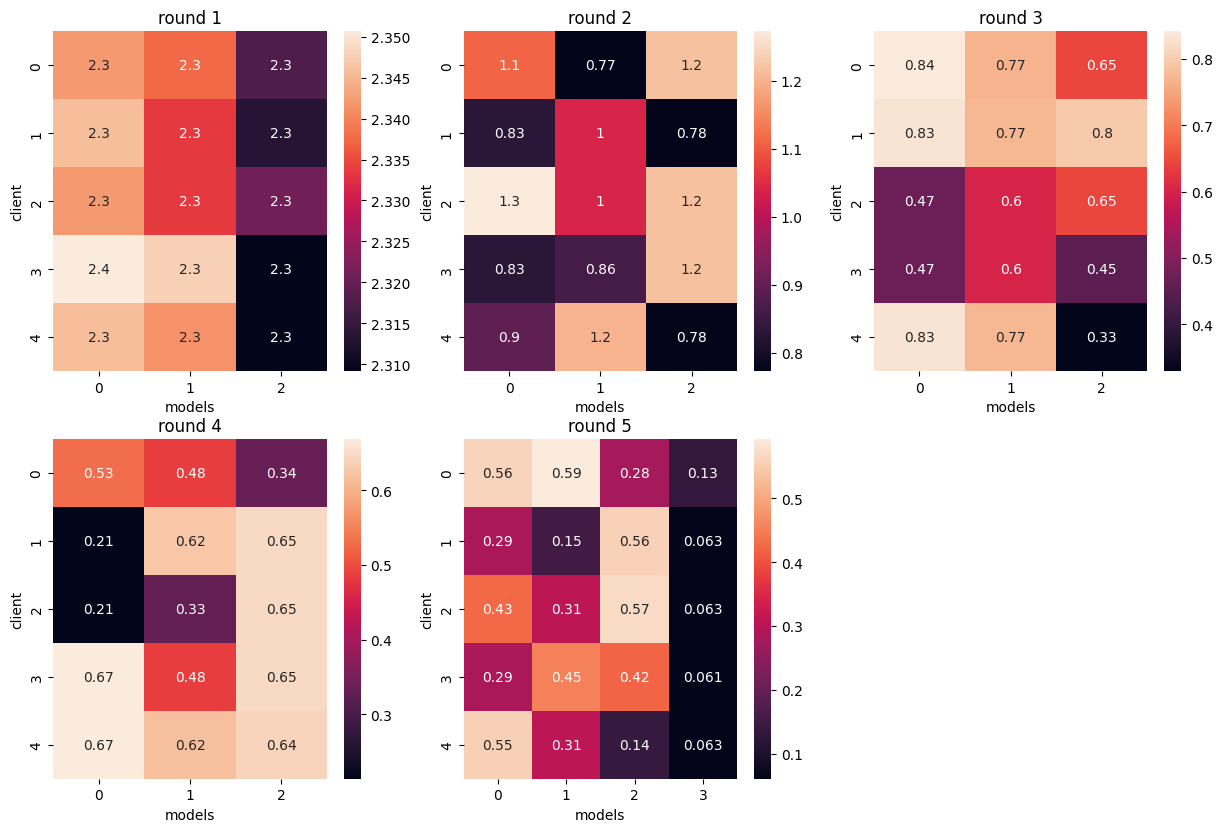

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

ax=plt.axes()

c=1
for idx,i in enumerate(rounds_losses):
    plt.subplot(3,3,c)
    sns.heatmap(np.array(i),annot=True)
    plt.title(f"round {idx+1}")
    plt.xlabel("models")
    plt.ylabel("client")
    c+=1

In [57]:
for i in range(len(rounds_losses)):
    print(f"round {i+1}")
    print()
    for j in range(num_clients):
        print(rounds_losses[i][j])

round 1

[2.34193134 2.33764243 2.31773043]
[2.34574699 2.33359528 2.31332421]
[2.34193134 2.33359528 2.32113957]
[2.35067153 2.34774685 2.30915165]
[2.34574699 2.34139991 2.30915165]
round 2

[1.11018646 0.7727614  1.21632373]
[0.82857913 1.04159987 0.77591962]
[1.2724669  1.04159987 1.21632373]
[0.82857913 0.86334693 1.21632373]
[0.89738405 1.20017362 0.77591962]
round 3

[0.8417058  0.76694751 0.64539891]
[0.83038354 0.77351242 0.79663163]
[0.47054127 0.60267299 0.64539891]
[0.47054127 0.60267299 0.45344952]
[0.83038354 0.77351242 0.32942805]
round 4

[0.52894306 0.48401195 0.33531672]
[0.21402662 0.62487429 0.64680362]
[0.21402662 0.3328642  0.64680362]
[0.66858971 0.48401195 0.64680362]
[0.66858971 0.61563843 0.64105177]
round 5

[0.56076843 0.59305948 0.28095531 0.13190994]
[0.28650206 0.15425925 0.55606031 0.06301967]
[0.42524603 0.30817166 0.56930953 0.06301967]
[0.28650206 0.45298731 0.41890591 0.06067706]
[0.55469805 0.30817166 0.13573255 0.06301967]


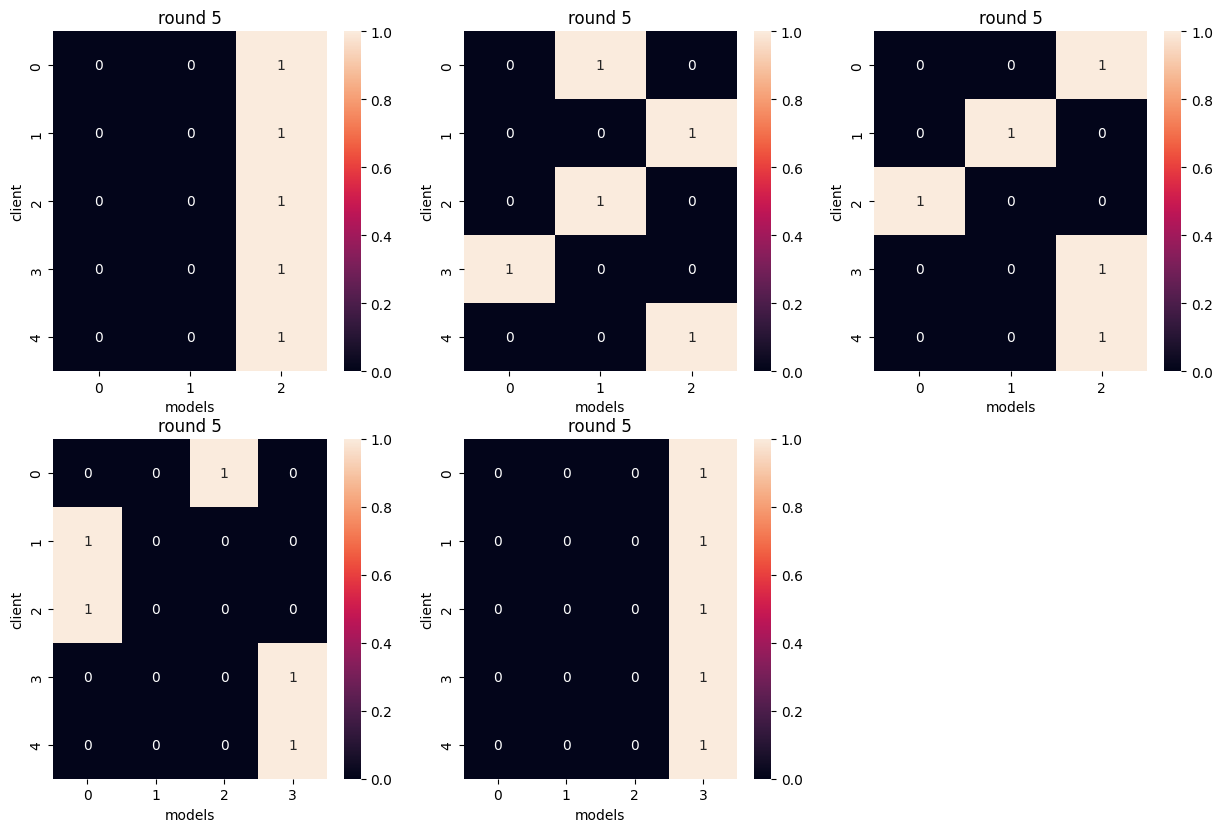

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

c=1
for i in tally_arr:
    plt.subplot(3,3,c)
    sns.heatmap(np.array(i),annot=True)
    plt.title(f"round {idx+1}")
    plt.xlabel("models")
    plt.ylabel("client")
    c+=1

In [60]:
for x,i in enumerate(tally_arr):
    print(f"round : {x+1}")
    print()
    for y,j in enumerate(i):
        print(f"client {y+1}")
        for k in j:
            print(int(k),end="  ")
        print()
    print()

round : 1

client 1
0  0  1  
client 2
0  0  1  
client 3
0  0  1  
client 4
0  0  1  
client 5
0  0  1  

round : 2

client 1
0  1  0  
client 2
0  0  1  
client 3
0  1  0  
client 4
1  0  0  
client 5
0  0  1  

round : 3

client 1
0  0  1  
client 2
0  1  0  
client 3
1  0  0  
client 4
0  0  1  
client 5
0  0  1  

round : 4

client 1
0  0  1  0  
client 2
1  0  0  0  
client 3
1  0  0  0  
client 4
0  0  0  1  
client 5
0  0  0  1  

round : 5

client 1
0  0  0  1  
client 2
0  0  0  1  
client 3
0  0  0  1  
client 4
0  0  0  1  
client 5
0  0  0  1  



# rough work

In [ ]:
tally_arr

In [ ]:
x=loss_copy[0]+loss_copy[1]

In [ ]:
print(x)

In [ ]:
type(loss_copy)

In [ ]:
print(tally_arr)

In [ ]:
#test
type(rounds_losses)

In [ ]:
new_arr=np.zeros((num_clients,))
print(new_arr)
xy=np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])
np.column_stack((xy,new_arr))

In [ ]:
z=np.stack([xy]*5,axis=1)
#z=np.column_stack((z,new_arr))
temp=list(z[:1+1])
new_arr_e=[np.column_stack((z[x],new_arr)) for x in range(2,len(z))]
print(temp)

In [ ]:
print(new_arr_e)

In [ ]:
model_weights=global_models[1].get_weights()

In [ ]:
print(model_weights)